# Bank Institution Term Deposit Predictive Model

The goal is to find a model that can predict which future clients who would subscribe to their term deposit. 

Having such an effective predictive model can help increase the campaign efficiency as they would be able to identify customers who would subscribe to their term deposit and thereby direct their marketing efforts to them. 

This would help them better manage their resources (e.g human effort, phone calls, time).

## Import the data

In [1]:
import sys
import pydotplus

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import std
from numpy import mean
from sklearn import svm
from scipy import stats
from io import StringIO
from keras import regularizers
from xgboost import XGBClassifier
from IPython.display import Image  
from sklearn.manifold import TSNE
from keras.layers import Input, Dense
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential, Model
from six import StringIO  
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Dense, Dropout, Input
from sklearn import preprocessing, metrics, model_selection

In [2]:
#set seaborn style
sns.set(style="darkgrid")

colour_palette = "tab10"
sns.set_palette(colour_palette)

In [3]:
#Import the data into a dataframe called data through github link. 
#Set low memory to false because the dataset is large.
 
bank_additional_full = 'https://raw.githubusercontent.com/mwi-kali/Bank-Institution-Term-Deposit-Predictive-Model/master/data/bank-additional-full.csv'

data_bank_additional_full = pd.read_csv(bank_additional_full, sep=';', low_memory = False)

In [4]:
data_bank_additional_full.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

## Data Exploration

This section attempts to understand the data. 

In [5]:
print("In total: ", data_bank_additional_full.shape)
print("Missing data in total: ", data_bank_additional_full.isnull().sum().sum())
data_bank_additional_full.describe(include='all')

In total:  (41188, 21)
Missing data in total:  0


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


# Classification Model for Predicting Term Deposit

## Preprocessing

### Encoding categorical variables 
Using label encoder to transform them into numerical columns. 

It encodes target labels with value between 0 and n_classes-1. This approach is very simple and it involves converting each value in a column to a number.

In [6]:
# Replacing categorical values with numerical values
label_encoder = LabelEncoder()
all_columns = list(data_bank_additional_full.columns)
for x in all_columns:
    if type(data_bank_additional_full[x][0]) == str:
        try:
            data_bank_additional_full[x] = label_encoder.fit_transform(data_bank_additional_full[x])
        except:
            continue

### Handling outliers
Using by replacing it with central measures of tendancies.


In [7]:
all_columns = list(data_bank_additional_full.iloc[:,:20].columns)
for x in all_columns:
    try:
        data_bank_additional_full[x] = np.where(data_bank_additional_full[x] > data_bank_additional_full[x].quantile(0.975), data_bank_additional_full[x].quantile(0.50), data_bank_additional_full[x])
        data_bank_additional_full[x] = np.where(data_bank_additional_full[x] < data_bank_additional_full[x].quantile(0.025), data_bank_additional_full[x].quantile(0.50), data_bank_additional_full[x])
    except TypeError:
        continue

### Scaler to rescale all numerical columns
Using StandardScaler().

It standardizes features by removing the mean and scaling to unit variance.

In [8]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(data_bank_additional_full.iloc[:,:20])
data_bank_additional_fullish = pd.DataFrame(scaled_df,columns = all_columns)
data_bank_additional_fullish['y'] = data_bank_additional_full['y']
data_bank_additional_full = data_bank_additional_fullish

### Feature Engineering
Transforming and Aggregating columns to create better features.

In [9]:
X = data_bank_additional_full[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan','contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays','previous', 'poutcome', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']]
y = data_bank_additional_full['y']

### Dimensionality Reductions Techniques.

#### TSNE (t-distributed Stochastic Neighbor Embedding)

It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

In [10]:
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X)
X_tsne = pd.DataFrame(X_tsne)

#### Autoencoders
Autoencoder is an unsupervised artificial neural network. Its procedure starts compressing the original data into a shortcode ignoring noise. Then, the algorithm uncompresses that code to generate an image as close as possible to the original input.

In [11]:
# Choose size of the encoded representations (reduce our initial features to this number)
encoding_dim = 15
# Define input layer
input_data = Input(shape=(X.shape[1],))
# Define encoding layer
encoded = Dense(encoding_dim, activation='elu')(input_data)
# Define decoding layer
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
# Create the autoencoder model
autoencoder = Model(input_data, decoded)
#Compile the autoencoder model
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
#Fit to set and save to hist_auto for plotting purposes
hist_auto = autoencoder.fit(X, X,epochs=500,batch_size=256,shuffle=True)

Epoch 1/500
161/161 [==============================] - 0s 2ms/step - loss: 0.2686
Epoch 2/500
161/161 [==============================] - 0s 2ms/step - loss: -1.1473
Epoch 3/500
161/161 [==============================] - 0s 1ms/step - loss: -3.8733
Epoch 4/500
161/161 [==============================] - 0s 2ms/step - loss: -8.3611
Epoch 5/500
161/161 [==============================] - 0s 1ms/step - loss: -14.7579
Epoch 6/500
161/161 [==============================] - 0s 1ms/step - loss: -23.0304
Epoch 7/500
161/161 [==============================] - 0s 1ms/step - loss: -33.1218
Epoch 8/500
161/161 [==============================] - 0s 2ms/step - loss: -44.9012
Epoch 9/500
161/161 [==============================] - 0s 1ms/step - loss: -58.2704A: 0s - loss: -54.2
Epoch 10/500
161/161 [==============================] - 0s 1ms/step - loss: -73.1770
Epoch 11/500
161/161 [==============================] - 0s 1ms/step - loss: -89.5799
Epoch 12/500
161/161 [==============================] - 0s 2

161/161 [==============================] - 0s 2ms/step - loss: -5230.9121
Epoch 96/500
161/161 [==============================] - 0s 2ms/step - loss: -5333.6304
Epoch 97/500
161/161 [==============================] - 0s 2ms/step - loss: -5437.2642
Epoch 98/500
161/161 [==============================] - 0s 2ms/step - loss: -5541.9150
Epoch 99/500
161/161 [==============================] - 0s 2ms/step - loss: -5647.5386
Epoch 100/500
161/161 [==============================] - 0s 2ms/step - loss: -5754.0986
Epoch 101/500
161/161 [==============================] - 0s 2ms/step - loss: -5861.6050
Epoch 102/500
161/161 [==============================] - 0s 2ms/step - loss: -5970.0171
Epoch 103/500
161/161 [==============================] - 0s 2ms/step - loss: -6079.4316
Epoch 104/500
161/161 [==============================] - 0s 2ms/step - loss: -6189.7778
Epoch 105/500
161/161 [==============================] - 0s 2ms/step - loss: -6301.0786
Epoch 106/500
161/161 [===========================

161/161 [==============================] - 0s 2ms/step - loss: -18483.7734
Epoch 187/500
161/161 [==============================] - 0s 1ms/step - loss: -18673.1191
Epoch 188/500
161/161 [==============================] - 0s 1ms/step - loss: -18863.4336
Epoch 189/500
161/161 [==============================] - 0s 1ms/step - loss: -19054.5605
Epoch 190/500
161/161 [==============================] - 0s 1ms/step - loss: -19246.7246
Epoch 191/500
161/161 [==============================] - 0s 2ms/step - loss: -19439.8105
Epoch 192/500
161/161 [==============================] - 0s 2ms/step - loss: -19633.7461
Epoch 193/500
161/161 [==============================] - 0s 2ms/step - loss: -19828.5977
Epoch 194/500
161/161 [==============================] - 0s 2ms/step - loss: -20024.4473
Epoch 195/500
161/161 [==============================] - 0s 2ms/step - loss: -20221.2812
Epoch 196/500
161/161 [==============================] - 0s 2ms/step - loss: -20419.0020
Epoch 197/500
161/161 [============

161/161 [==============================] - 0s 2ms/step - loss: -39562.1797
Epoch 278/500
161/161 [==============================] - 0s 1ms/step - loss: -39837.1406
Epoch 279/500
161/161 [==============================] - 0s 1ms/step - loss: -40113.0469
Epoch 280/500
161/161 [==============================] - 0s 1ms/step - loss: -40389.7227
Epoch 281/500
161/161 [==============================] - 0s 2ms/step - loss: -40667.3125
Epoch 282/500
161/161 [==============================] - 0s 2ms/step - loss: -40945.8828
Epoch 283/500
161/161 [==============================] - 0s 1ms/step - loss: -41225.4609
Epoch 284/500
161/161 [==============================] - 0s 2ms/step - loss: -41505.8945
Epoch 285/500
161/161 [==============================] - 0s 2ms/step - loss: -41787.0938
Epoch 286/500
161/161 [==============================] - 0s 2ms/step - loss: -42069.3203
Epoch 287/500
161/161 [==============================] - 0s 2ms/step - loss: -42352.5625
Epoch 288/500
161/161 [============

161/161 [==============================] - 0s 2ms/step - loss: -68389.5938
Epoch 369/500
161/161 [==============================] - 0s 1ms/step - loss: -68749.4297
Epoch 370/500
161/161 [==============================] - 0s 2ms/step - loss: -69110.2422
Epoch 371/500
161/161 [==============================] - 0s 2ms/step - loss: -69472.0234
Epoch 372/500
161/161 [==============================] - 0s 2ms/step - loss: -69834.6484
Epoch 373/500
161/161 [==============================] - 0s 2ms/step - loss: -70198.1250
Epoch 374/500
161/161 [==============================] - 0s 2ms/step - loss: -70562.7344
Epoch 375/500
161/161 [==============================] - 0s 1ms/step - loss: -70928.1641
Epoch 376/500
161/161 [==============================] - 0s 2ms/step - loss: -71294.3438: 0s - loss: -71653.
Epoch 377/500
161/161 [==============================] - 0s 2ms/step - loss: -71661.5000
Epoch 378/500
161/161 [==============================] - 0s 2ms/step - loss: -72029.5156
Epoch 379/500
1

161/161 [==============================] - 0s 2ms/step - loss: -104931.1953
Epoch 460/500
161/161 [==============================] - 0s 2ms/step - loss: -105375.2891
Epoch 461/500
161/161 [==============================] - 0s 2ms/step - loss: -105820.4766
Epoch 462/500
161/161 [==============================] - 0s 2ms/step - loss: -106266.6016
Epoch 463/500
161/161 [==============================] - 0s 2ms/step - loss: -106713.6484A: 0s - loss: -106571.531
Epoch 464/500
161/161 [==============================] - 0s 2ms/step - loss: -107161.5859
Epoch 465/500
161/161 [==============================] - 0s 2ms/step - loss: -107610.5703
Epoch 466/500
161/161 [==============================] - 0s 2ms/step - loss: -108059.9844
Epoch 467/500
161/161 [==============================] - 0s 2ms/step - loss: -108510.5391
Epoch 468/500
161/161 [==============================] - 0s 2ms/step - loss: -108962.1562
Epoch 469/500
161/161 [==============================] - 0s 2ms/step - loss: -109414.6250

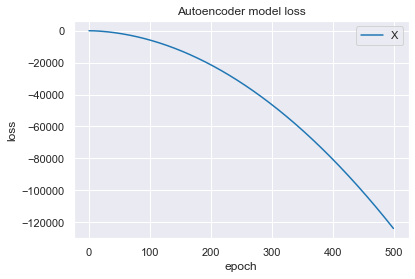

In [12]:
# Summarize history for loss
plt.figure()
plt.plot(hist_auto.history['loss'])
plt.title('Autoencoder model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['X'], loc='upper right')
plt.show()

In [13]:
# Create a separate model (encoder) in order to make encodings (first part of the autoencoder model)
encoder = Model(input_data, encoded)

# Create a placeholder for an encoded input
encoded_input = Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Encode and decode our test set (compare them visually just to get a first insight of the autoencoder's performance)
encoded_X = encoder.predict(X)
decoded_output = decoder.predict(encoded_X)

#Encode data set from above using the encoder
encoded_X = encoder.predict(X)

model = Sequential()
model.add(Dense(16, input_dim=encoded_X.shape[1],kernel_initializer='normal',activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="binary_crossentropy", optimizer='adam')

history = model.fit(encoded_X, y, validation_split=0.2, epochs=100, batch_size=64)

Epoch 1/100
515/515 [==============================] - 1s 2ms/step - loss: 0.7349 - val_loss: 0.7947
Epoch 2/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2451 - val_loss: 0.6352
Epoch 3/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2248 - val_loss: 0.7784
Epoch 4/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2169 - val_loss: 0.6023
Epoch 5/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2160 - val_loss: 0.6813
Epoch 6/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2141 - val_loss: 0.6114
Epoch 7/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2124 - val_loss: 0.6667
Epoch 8/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2125 - val_loss: 0.6701
Epoch 9/100
515/515 [==============================] - 1s 2ms/step - loss: 0.2110 - val_loss: 0.6834
Epoch 10/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2118 - val_lo

Epoch 79/100
515/515 [==============================] - 1s 2ms/step - loss: 0.2038 - val_loss: 0.7040
Epoch 80/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2051 - val_loss: 0.6423
Epoch 81/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2036 - val_loss: 0.7197
Epoch 82/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2046 - val_loss: 0.7167
Epoch 83/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2028 - val_loss: 0.6860
Epoch 84/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2045 - val_loss: 0.6537
Epoch 85/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2049 - val_loss: 0.7090
Epoch 86/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2035 - val_loss: 0.6583
Epoch 87/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2035 - val_loss: 0.6695
Epoch 88/100
515/515 [==============================] - 1s 2ms/step - loss: 0.2028

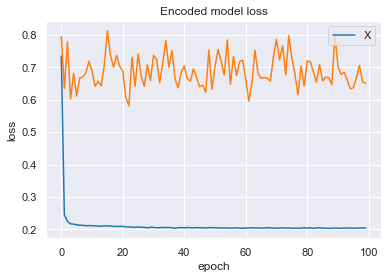

In [14]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Encoded model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['X'], loc='upper right')
plt.show()

In [15]:
#Predict on set
predictions_prob = model.predict(encoded_X)
predictions_prob = predictions_prob[:,0]

predictions = np.where(predictions_prob > 0.5, 1, 0) 
#Turn probability to 0-1 binary output

#Print accuracy
acc = metrics.accuracy_score(y, predictions)
print('Overall accuracy of Neural Network model:', acc)

Overall accuracy of Neural Network model: 0.8899193939982519


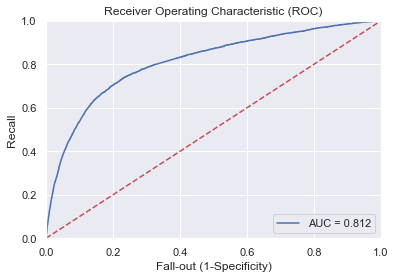

In [16]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = metrics.roc_curve(y, predictions_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

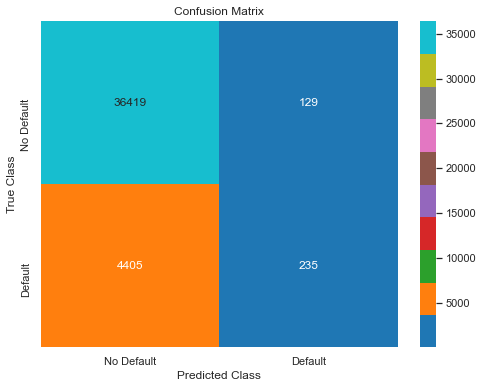

In [17]:
#Print Confusion Matrix
cm = metrics.confusion_matrix(y, predictions)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap=colour_palette, vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [18]:
decoded_output = pd.DataFrame(decoded_output)

In [19]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 15)                315       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                320       
Total params: 635
Trainable params: 635
Non-trainable params: 0
_________________________________________________________________


#### PCA
Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

In [20]:
pca = PCA()
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)

### Choosing Dimensionality Reductions Techniques

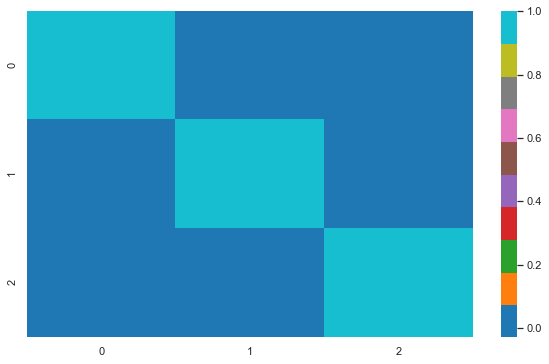

In [21]:
figure = plt.figure(figsize=(10,6))
corrMatrix = X_tsne.corr()
sns.heatmap(corrMatrix, annot=False,cmap=colour_palette)
plt.show()

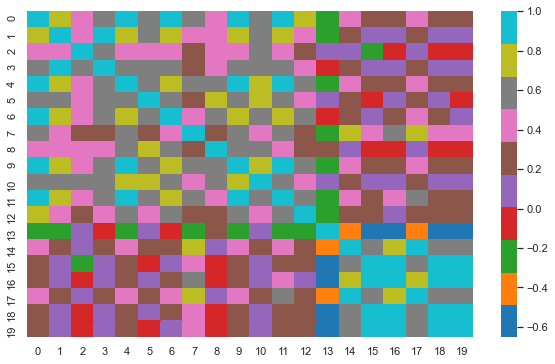

In [22]:
figure = plt.figure(figsize=(10,6))
corrMatrix = decoded_output.corr()
sns.heatmap(corrMatrix, annot=False,cmap=colour_palette)
plt.show()

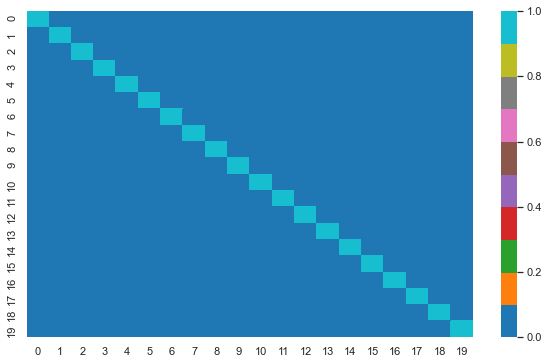

In [23]:
figure = plt.figure(figsize=(10,6))
corrMatrix = X_pca.corr()
sns.heatmap(corrMatrix, annot=False,cmap=colour_palette)
plt.show()

The dimensionality reduction technique chosen is Autoencoders. Autoencoder output is able to compress the information better into low dimensional latent space leveraging its capability to model complex nonlinear functions. The resulting dataset from autoencoders give a higher accuracy than the other techniques.

With t-distributed stochastic neighbor embedding, the dimensions a fewer for a dataset that originally had 21 features. This is seen with its reduction in accuracy for the machine learning models used. It has the lowest accuracy of the three techniques.

With principal component analysis, the accuracy of the model is lower than that with the autoencoder when applying the resulting dataset from the principal component analysis.

## Train, Test Split

90% for training and 10% for testing

In [24]:
X_train, X_test, y_train, y_test = train_test_split(decoded_output, y, test_size=0.1, random_state=1)

## Selecting Machine Learning Models

Cross validation to select the best three machine learning models.Cross validation techniques used are Stratified K-fold and K-fold.

#### Helper function

In [25]:
class helper:
    def __init__(self):
        print ("Helper object created")
    def confusion(self, y_pred):
        cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
        class_names=[0,1] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)

        # create heatmap
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap=colour_palette ,fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

    def roc_plot(self,model):
        y_pred_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
        print("auc="+str(auc))
        plt.legend(loc=4)
        plt.show()

    def s_kfold(self,model):
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

        scores = cross_val_score(model, X_train, y_train, cv=skfold,scoring='accuracy')
        print('\nCross-Validation Accuracy Scores', scores)

        scores = pd.Series(scores)
        print('\nThe minimum Cross-Validation Accuracy is  %.4f ' % scores.min())
        print('\nThe mean Cross-Validation Accuracy is  %.4f ' % scores.mean())
        print('\nThe maximum Cross-Validation Accuracy is  %.4f ' % scores.max())
        return scores

    def kfold(self,model):
        kfold = KFold(n_splits=5, shuffle=True, random_state=1)

        scores = cross_val_score(model, X_train, y_train, cv=kfold,scoring='accuracy')
        print('\nCross-Validation Accuracy Scores', scores)

        scores = pd.Series(scores)
        print('\nThe minimum Cross-Validation Accuracy is  %.4f ' % scores.min())
        print('\nThe mean Cross-Validation Accuracy is  %.4f ' % scores.mean())
        print('\nThe maximum Cross-Validation Accuracy is  %.4f ' % scores.max())

    def calc_metrics(self,y_pred):
        print("\nF1 Score: %.4f " % metrics.f1_score(y_test, y_pred))
        print("\nAccuracy: %.4f " % metrics.accuracy_score(y_test, y_pred))
        print("\nPrecision: %.4f " % metrics.precision_score(y_test, y_pred))
        print("\nRecall: %.4f " % metrics.recall_score(y_test, y_pred))

In [26]:
helper = helper()

Helper object created


### Logistic Regression Model

Logistic regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes.

In [27]:
# instantiate the model (using the default parameters)
logistic_regressor = LogisticRegression()

# fit the model with data
logistic_regressor = logistic_regressor.fit(X_train,y_train)

# predict
y_pred = logistic_regressor.predict(X_test)

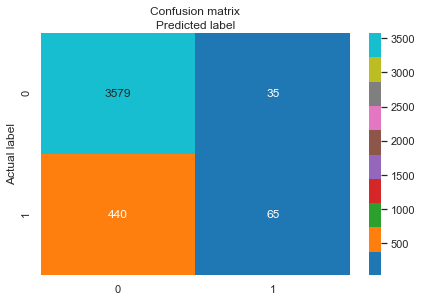

In [28]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [29]:
log = helper.s_kfold(logistic_regressor)


Cross-Validation Accuracy Scores [0.89627731 0.89425411 0.89182627 0.89304019 0.89248617]

The minimum Cross-Validation Accuracy is  0.8918 

The mean Cross-Validation Accuracy is  0.8936 

The maximum Cross-Validation Accuracy is  0.8963 


##### K-fold

In [30]:
helper.kfold(logistic_regressor)


Cross-Validation Accuracy Scores [0.89937955 0.88791476 0.89398435 0.89209603 0.89464454]

The minimum Cross-Validation Accuracy is  0.8879 

The mean Cross-Validation Accuracy is  0.8936 

The maximum Cross-Validation Accuracy is  0.8994 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7666040206677004


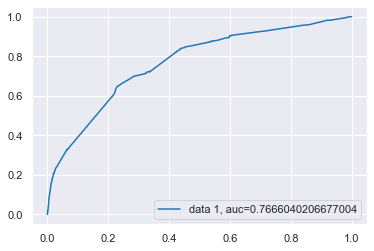

In [31]:
helper.roc_plot(logistic_regressor)

AUC score for the case is 0.7766. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [32]:
helper.calc_metrics(y_pred)


F1 Score: 0.2149 

Accuracy: 0.8847 

Precision: 0.6500 

Recall: 0.1287 


### XGBoost

Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. 

In [33]:
# instantiate the model (using the default parameters)
xgboost_classifier = XGBClassifier()

# fit the model with data
xgboost_classifier = xgboost_classifier.fit(X_train,y_train)

# predict
y_pred = xgboost_classifier.predict(X_test)

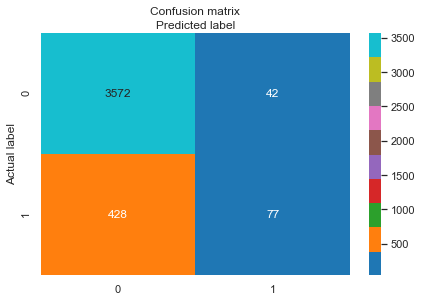

In [34]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [35]:
boost = helper.s_kfold(xgboost_classifier)


Cross-Validation Accuracy Scores [0.89546803 0.89357971 0.89277043 0.89047748 0.89370026]

The minimum Cross-Validation Accuracy is  0.8905 

The mean Cross-Validation Accuracy is  0.8932 

The maximum Cross-Validation Accuracy is  0.8955 


##### K-fold

In [36]:
helper.kfold(xgboost_classifier)


Cross-Validation Accuracy Scores [0.89735635 0.88710548 0.89560291 0.89209603 0.89464454]

The minimum Cross-Validation Accuracy is  0.8871 

The mean Cross-Validation Accuracy is  0.8934 

The maximum Cross-Validation Accuracy is  0.8974 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7767962324732751


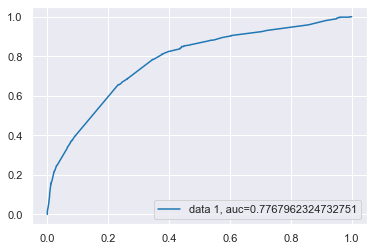

In [37]:
helper.roc_plot(xgboost_classifier)

AUC score for the case is 0.7812. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [38]:
helper.calc_metrics(y_pred)


F1 Score: 0.2468 

Accuracy: 0.8859 

Precision: 0.6471 

Recall: 0.1525 


### Multilayer Perceptron

A multilayer perceptron or MLP represents a vast artificial neural network, meaning simply that it features more than one perceptron. This gathering of perceptrons is established from an input layer meant to receive the signal, an output layer responsible for a decision or prediction in regards to the input, and an arbitrary number of hidden layers that represent the true computational power of the MLP.

In [39]:
# create mutli-layer perceptron classifier
perceptron_classifier = MLPClassifier()

# train
perceptron_classifier = perceptron_classifier.fit(X_train,y_train)

# make predictions
y_pred = perceptron_classifier.predict(X_test)

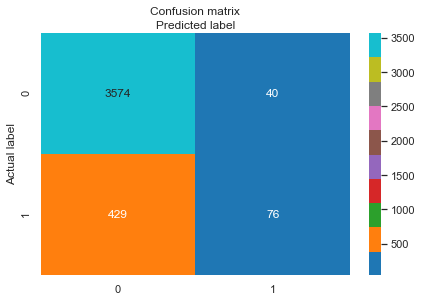

In [40]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [41]:
multi = helper.s_kfold(perceptron_classifier)


Cross-Validation Accuracy Scores [0.89600755 0.89452387 0.89357971 0.89020772 0.89450965]

The minimum Cross-Validation Accuracy is  0.8902 

The mean Cross-Validation Accuracy is  0.8938 

The maximum Cross-Validation Accuracy is  0.8960 


##### K-fold

In [42]:
helper.kfold(perceptron_classifier)


Cross-Validation Accuracy Scores [0.89830051 0.88818452 0.89627731 0.89236579 0.89518414]

The minimum Cross-Validation Accuracy is  0.8882 

The mean Cross-Validation Accuracy is  0.8941 

The maximum Cross-Validation Accuracy is  0.8983 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7754812144191728


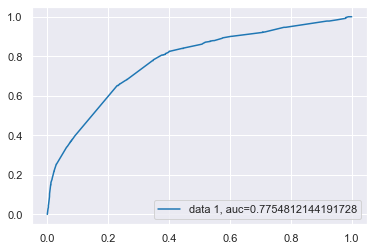

In [43]:
helper.roc_plot(perceptron_classifier)

AUC score for the case is 0.7833. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [44]:
helper.calc_metrics(y_pred)


F1 Score: 0.2448 

Accuracy: 0.8861 

Precision: 0.6552 

Recall: 0.1505 


### Support Vector Machine

SVM offers very high accuracy compared to other classifiers such as logistic regression, and decision trees. It is known for its kernel trick to handle nonlinear input spaces. It is used in a variety of applications such as face detection, intrusion detection, classification of emails, news articles and web pages, classification of genes, and handwriting recognition.

In [45]:
#Create a svm Classifier
support_vector_classifier = svm.SVC(kernel='linear', probability=True)

#Train the model using the training sets
support_vector_classifier = support_vector_classifier.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = support_vector_classifier.predict(X_test)

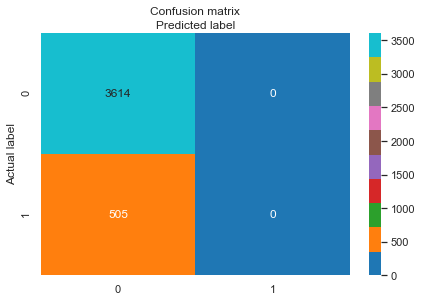

In [46]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [47]:
svm = helper.s_kfold(support_vector_classifier)


Cross-Validation Accuracy Scores [0.88845428 0.88845428 0.88845428 0.8869706  0.88843923]

The minimum Cross-Validation Accuracy is  0.8870 

The mean Cross-Validation Accuracy is  0.8882 

The maximum Cross-Validation Accuracy is  0.8885 


##### K-fold

In [48]:
helper.kfold(support_vector_classifier)


Cross-Validation Accuracy Scores [0.88926356 0.88454276 0.88804964 0.88319396 0.89275597]

The minimum Cross-Validation Accuracy is  0.8832 

The mean Cross-Validation Accuracy is  0.8876 

The maximum Cross-Validation Accuracy is  0.8928 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.5584243344090911


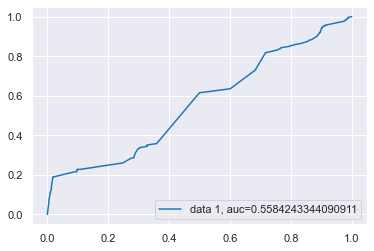

In [49]:
helper.roc_plot(support_vector_classifier)

AUC score for the case is 0.5362. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [50]:
helper.calc_metrics(y_pred)


F1 Score: 0.0000 

Accuracy: 0.8774 

Precision: 0.0000 

Recall: 0.0000 


C:\Users\smwik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Trees

A decision tree is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome. The topmost node in a decision tree is known as the root node. 

It learns to partition on the basis of the attribute value. It partitions the tree in recursively manner call recursive partitioning. This flowchart-like structure helps you in decision making. 

It's visualization like a flowchart diagram which easily mimics the human level thinking. That is why decision trees are easy to understand and interpret.

In [51]:
# Create Decision Tree classifer object
decision_tree_classifer = DecisionTreeClassifier(max_depth=5)

# Train Decision Tree Classifer
decision_tree_classifer = decision_tree_classifer.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = decision_tree_classifer.predict(X_test)

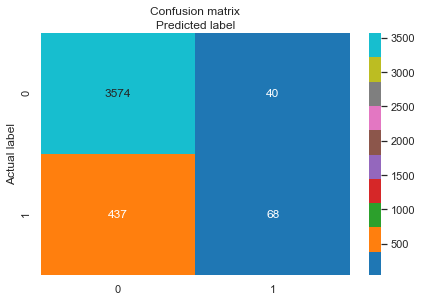

In [52]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [53]:
trees = helper.s_kfold(decision_tree_classifer)


Cross-Validation Accuracy Scores [0.89560291 0.89155651 0.89290531 0.88993796 0.89491434]

The minimum Cross-Validation Accuracy is  0.8899 

The mean Cross-Validation Accuracy is  0.8930 

The maximum Cross-Validation Accuracy is  0.8956 


##### K-fold

In [54]:
helper.kfold(decision_tree_classifer)


Cross-Validation Accuracy Scores [0.89600755 0.88737524 0.89546803 0.89115187 0.89585863]

The minimum Cross-Validation Accuracy is  0.8874 

The mean Cross-Validation Accuracy is  0.8932 

The maximum Cross-Validation Accuracy is  0.8960 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7731152777701678


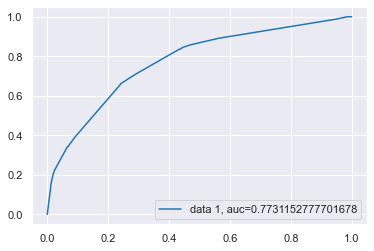

In [55]:
helper.roc_plot(decision_tree_classifer)

AUC score for the case is 0.7760. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [56]:
helper.calc_metrics(y_pred)


F1 Score: 0.2219 

Accuracy: 0.8842 

Precision: 0.6296 

Recall: 0.1347 


### Random Forests

Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. 

A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

In [57]:
# create classifier object 
random_forest_classifier = RandomForestClassifier() 
  
# fit the classifier with x and y data 
random_forest_classifier = random_forest_classifier.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = random_forest_classifier.predict(X_test)

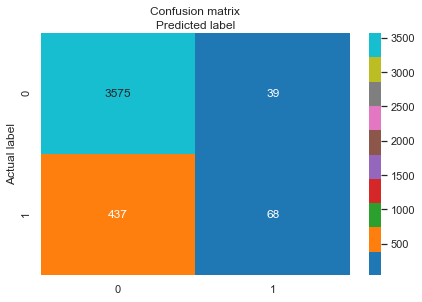

In [58]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [59]:
rand = helper.s_kfold(random_forest_classifier)


Cross-Validation Accuracy Scores [0.89438899 0.89398435 0.89128675 0.89020772 0.89208148]

The minimum Cross-Validation Accuracy is  0.8902 

The mean Cross-Validation Accuracy is  0.8924 

The maximum Cross-Validation Accuracy is  0.8944 


##### K-fold

In [60]:
helper.kfold(random_forest_classifier)


Cross-Validation Accuracy Scores [0.89641219 0.8869706  0.89533315 0.89142163 0.89491434]

The minimum Cross-Validation Accuracy is  0.8870 

The mean Cross-Validation Accuracy is  0.8930 

The maximum Cross-Validation Accuracy is  0.8964 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7727777564696148


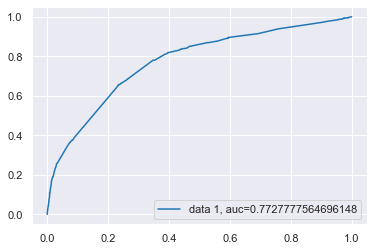

In [61]:
helper.roc_plot(random_forest_classifier)

AUC score for the case is 0.7761. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [62]:
helper.calc_metrics(y_pred)


F1 Score: 0.2222 

Accuracy: 0.8844 

Precision: 0.6355 

Recall: 0.1347 


In [63]:
evaluation = pd.DataFrame()
evaluation['Logistic Regression'] = log
evaluation['XGBoost'] = boost
evaluation['Multilayer Perceptron'] = multi
evaluation['Support Vector Machine'] = svm
evaluation['Decision Trees'] = trees
evaluation['Random Forests'] = rand
evaluation['Validation Round'] = list(['First', 'Second', 'Third', 'Fourth', 'Fifth'])

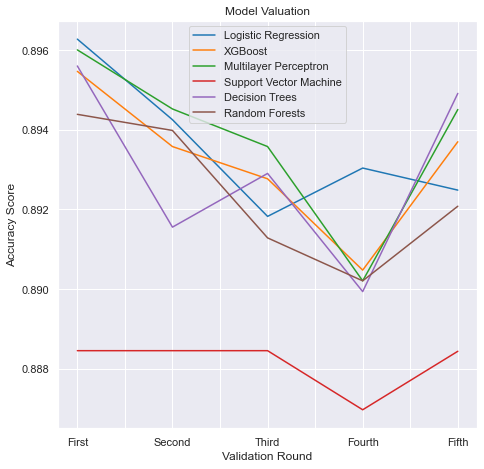

In [64]:
figure = plt.figure(figsize=(7.5,7.5))
ax = plt.gca()
evaluation.plot(kind='line',x='Validation Round',y='Logistic Regression',ax=ax)
evaluation.plot(kind='line',x='Validation Round',y='XGBoost',ax=ax)
evaluation.plot(kind='line',x='Validation Round',y='Multilayer Perceptron',ax=ax)
evaluation.plot(kind='line',x='Validation Round',y='Support Vector Machine',ax=ax)
evaluation.plot(kind='line',x='Validation Round',y='Decision Trees',ax=ax)
evaluation.plot(kind='line',x='Validation Round',y='Random Forests',ax=ax)
plt.title('Model Valuation')
plt.ylabel('Accuracy Score')
plt.show()

# References
Navlani, A., 2018. Decision Tree Classification In Python. [online] DataCamp Community. Available at: <https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python>.

Navlani, A., 2019. Support Vector Machines With Scikit-Learn. [online] DataCamp Community. Available at: <https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377086&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9076857&gclid=CjwKCAjwyo36BRAXEiwA24CwGa2OoIYBqmBWZL_KcePBXotc_Ky7MN5xnyT0eF-U0DcAQfgaQ9RS1RoCx0IQAvD_BwE>.

Navlani, A., 2020. Understanding Logistic Regression In Python. [online] DataCamp Community. Available at: <https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9076857&gclid=CjwKCAjwyo36BRAXEiwA24CwGW_AlFxbL4od4tD3zMDp3OzlVqetNSFDL_4xhwfQnyxxVXo9WJ2vlxoC6cwQAvD_BwE>.

Pathak, M., 2020. Using Xgboost In Python. [online] DataCamp Community. Available at: <https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9076857&gclid=CjwKCAjwyo36BRAXEiwA24CwGU0BzB6TeKG_Ns2Kv7MskUTbIAHkS3ZgfZan1mfSXTqwA9os59WGnxoCiuUQAvD_BwE>.

Pythonprogramminglanguage.com. 2020. Multilayer Perceptron - Learn Python. [online] Available at: <https://pythonprogramminglanguage.com/multilayer-perceptron/>.

Quantdare. 2020. Outliers Detection With Autoencoder, A Neural Network ⋆ Quantdare. [online] Available at: <https://quantdare.com/outliers-detection-with-autoencoder-neural-network/>.

Scikit-learn.org. 2020. Sklearn.Decomposition.PCA — Scikit-Learn 0.23.2 Documentation. [online] Available at: <https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html>.

Scikit-learn.org. 2020. Sklearn.Preprocessing.Standardscaler — Scikit-Learn 0.23.2 Documentation. [online] Available at: <https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html>.